# Plotting and comparing best fit models to data for fits to BAOs with and without the phase shift parameter 

### load stuff 

In [1]:
# Import some necessary modules
import os
import sys
sys.path.append("../../Barry/")     # Change this so that it points to where you have Barry installed
import pickle
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from chainconsumer import ChainConsumer     
from barry.cosmology.camb_generator import Omega_m_z


from barry.samplers import DynestySampler
from barry.config import setup
from barry.models import PowerBeutler2017, CorrBeutler2017
from barry.datasets.dataset_power_spectrum import PowerSpectrum_DESI_KP4
from barry.datasets.dataset_correlation_function import CorrelationFunction_DESI_KP4
from barry.fitter import Fitter
from barry.models.model import Correction # class for applying corrections to the likelihood function 
from barry.utils import weighted_avg_and_cov # function for getting avg and covariance 
from scipy.interpolate import CubicSpline 
# settings 
CV = False

### load in the data 

In [56]:

datafile="desi_kp4_abacus_cubicbox_pk_elg.pkl"

if CV:
    datafile="desi_kp4_abacus_cubicbox_cv_pk_elg.pkl"


dataset_pk = PowerSpectrum_DESI_KP4(
recon='sym',
fit_poles=[0, 2],
min_k=0.02,
max_k=0.30,
realisation=None,          # realisation=None loads the average of all the realisations
num_mocks=1000,            # Used for Hartlap/Sellentin correction if correction=Correction.HARTLAP or Correction.SELLENTIN
reduce_cov_factor=25,       # if = 1 Use standard covariance, even for the average
datafile=datafile,#"desi_kp4_abacus_cubicbox_pk_elg.pkl",
#datafile="desi_kp4_abacus_cubicbox_cv_pk_elg.pkl",   
data_location="/global/u1/a/abbew25/barryrepo/Barry/cosmodesi_KP4ELG_examplecode_make_picklefiles",
)

dataset_pk.set_realisation(None)

# print(dir(dataset_pk)) # attributes 

# print(dataset_pk.data.shape) # number of k measurements vs number of multipoles 
# print(dataset_pk.ks.shape)

# print(dataset_pk.w_pk.shape)


# print(dataset_pk.get_data()[0].keys())#[0]['pk'])#[['ndata']])#[['pk']])
# print(dataset_pk.get_data()[0]['w_scale'].shape)#[0]['pk'])#[['ndata']])#[['pk']])

# #plt.plot(dataset_pk.get_data()[0]['pk0'][0], dataset_pk.data[:,0]) # both of these give the monopole
# #plt.show()
# # print(dataset_pk.m_w_transform.shape)
# print(dataset_pk.w_transform.shape)

# # print(dataset_pk.w_transform.shape)

# # print(dataset_pk.ks.shape)
# # print(dataset_pk.m_w_mask.shape)

# # print(dataset_pk.w_pk.shape)
# print(dataset_pk.w_ks_input.shape)
# print(dataset_pk.w_ks_output.shape)

# #print(dataset_pk.get_data()[0][''])


# looking at data vs best fit models for polynomial vs spline method for broadband power spectrum fitting - fitting with beta 

Maximum likelihood nuisance parameters at maximum a posteriori point are [61948.28874042 13282.82697664  4190.81454713  1818.2994207
   957.69512373   617.42364172   437.54611528   138.59896981
 51079.91987851  9922.20431991  3082.82476078  1116.80228045
   538.36453457   337.7285309    194.98524572   297.73416064]
Chi squared/dof is 5048.932481369809/88 at these values


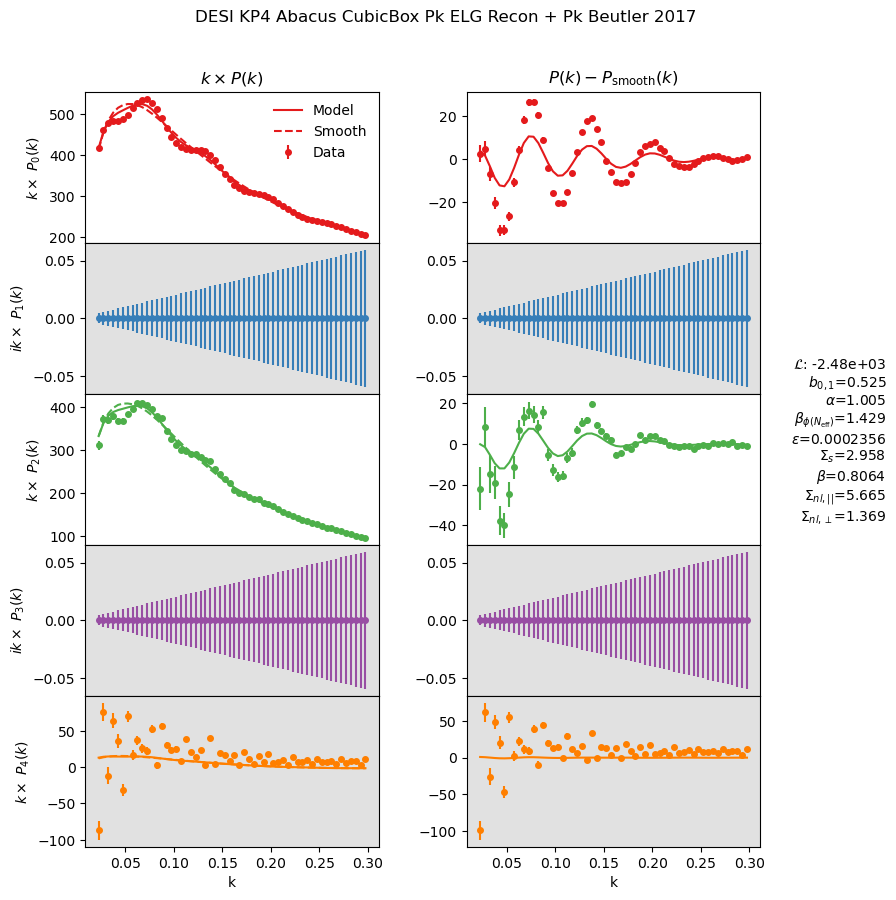

In [59]:
mocksandmodels = {
            # "poly best fit mean of mocks": [1.001, 0.000112, 5.725, 1.593, 0.4192, 1.065, 0.5167, 0.7962],
            # "poly best fit mean of mocks (CV)": [0.997, 0.0002107, 5.735, 1.248, 0.3287, 0.6999, 0.5103, 0.8161],
            "spline best fit mean of mocks": [1.005, 0.0002356, 5.665, 1.369, 2.958, 1.429, 0.525, 0.8064],
            #"spline best fit mean of mocks (CV)": [1.0018, 1.0013, 5.5584, 1.2013, 2.1888, 1.0549],
            #"poly default": [1.0, 0.0, 5.4, 1.5, 0.0, 1.0, 1.0, 1.0], 
            # "default model": [1.0, 0.0, 5.4, 1.5, 0.0, 1.0, 1.0, 1.0] 
            }
# mockmodel = "poly default"#best fit mean of mocks"
# plt.figure(figsize=(10,6))
for mockmodel in mocksandmodels:
    
# generating the default (correct) model for the data 
    model = PowerBeutler2017(
                    recon='sym',                   
                    isotropic=False,                              # 6 polynomial terms for P(k)
                    vary_phase_shift_neff=True, 
                    marg='full',
                    broadband_type=mockmodel.split()[0],
                    #use_class_or_camb='CLASS',
                    poly_poles=dataset_pk.fit_poles
    )
    # sigma_nl_par = {None: 8.7, "sym": 5.4}
    # sigma_nl_perp = {None: 4.0, "sym": 1.5}
    # sigma_s = {None: 3.5, "sym": 0.0}

    # model.set_default("sigma_nl_par", sigma_nl_par['sym'])#, min=0.0, max=20.0, sigma=4.0, prior="gaussian")
    # model.set_default("sigma_nl_perp", sigma_nl_perp['sym'])#, min=0.0, max=20.0, sigma=4.0, prior="gaussian")
    # model.set_default("sigma_s", sigma_s['sym'])#, min=0.0, max=20.0, sigma=4.0, prior="gaussian")
    # model.set_default('b{0}_{1}', 1.0)
    # model.set_default('beta', 1.0)

    cosmology = {
                "om": 0.3152,
                "h0": 0.6736,
                "z":  0.51,
                "ob": 0.0493,
                "ns": 0.9649,
                "mnu": 0.06,
                "reconsmoothscale": 15,
                "Neff": 3.044,
            }
    
    model.set_cosmology(cosmology) # initialises self.camb object 
    #model.camb._generate_data()
    model.camb.get_data()
    model.set_data(dataset_pk.get_data())
    ks = model.camb.ks
    # params_dict = {j.name: j.default for j in model.params}
    params_dict = {j.name: j.default for j in model.params}

    params_dict["b{0}_{1}"] = mocksandmodels[mockmodel][6]
    params_dict["alpha"] = mocksandmodels[mockmodel][0]
    params_dict["epsilon"] = mocksandmodels[mockmodel][1]
    params_dict["sigma_s"] = mocksandmodels[mockmodel][4]
    params_dict["beta"] = mocksandmodels[mockmodel][7]
    params_dict["sigma_nl_par"] = mocksandmodels[mockmodel][2]
    params_dict["sigma_nl_perp"] = mocksandmodels[mockmodel][3]
    params_dict["beta_phase_shift"] = mocksandmodels[mockmodel][5]


    new_chi_squared_default, dof, bband, mods_default, smooths_default = model.get_model_summary(params_dict, verbose=True)
    new_chi_squared_default, dof, bband, mods_default, smooths_default = model.plot(params_dict)

#     plt.plot(dataset_pk.ks, mods_default[0][0]/dataset_pk.data[:,0], label=mockmodel + r', $\chi^2 = %.2f$' % new_chi_squared_default)

# err = np.sqrt(np.diag(dataset_pk.cov[0:56,0:56]))
# plt.errorbar(dataset_pk.ks, dataset_pk.data[:,0] / dataset_pk.data[:,0], err/dataset_pk.data[:,0] , 
#     label='mock data mean', color='grey', linestyle='-.', alpha=0.5, markersize = 4, marker='o')

# plt.ylabel(r'$P(k)_{\mathrm{model}}/ P(k)_{\mathrm{25 mocks, mean}}$')
# plt.xlabel(r'$k$ $\mathrm{Mpc} h^{-1}$')

# plt.legend()
# plt.show()

In [124]:
print(dir(dataset_pk))

['__abstractmethods__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_agg_data', '_compute_cov', '_load_comp_file', '_load_winfit', '_load_winpk_file', '_rebin_data', 'corr', 'cosmology', 'cov', 'cov_fit', 'data', 'data_location', 'data_obj', 'fit_pole_indices', 'fit_poles', 'get_data', 'get_name', 'icov', 'icov_mw', 'icov_mwmw', 'icov_mww', 'icov_w', 'icov_ww', 'isotropic', 'ks', 'logger', 'm_transform', 'm_w_mask', 'm_w_transform', 'max_k', 'min_k', 'mock_data', 'name', 'ndata', 'nredshift_bins', 'nsmoothtypes', 'num_mocks', 'poles', 'postprocess', 'realisation', 'recon', 'reduce_cov_factor', 'set_cov', 'set_realisation', 'step_size', 'true_data', 

In [129]:
print(dataset_pk.data.shape)

(56, 5)
